# Inference of secundary properties from the SED fitting

In this notebook, we’ll explore how to derive secondary properties from the fitted spectral energy distribution (SED) model. These properties are not direct free parameters of the model but can instead be inferred from the primary fitted parameters.

It includes: Black Hole Mass, Outer Disk Radius (in units of Rg), Bolometric Luminosity, Eddington Ratio

In [21]:
# We need interactive plotting for this one. If this does not work, try "matplotlib notebook" after the percentile symbol.
%matplotlib widget 

# General imports
import os
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import pandas as pd # we will need, install if you don't have yet
import astropy.units as u

# Setting cosmology
cosmo = FlatLambdaCDM(H0=73, Om0=0.3, Tcmb0=2.725)

#Plotting configurations and imports
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams['font.size'] = 25
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['ytick.major.size']=   6
plt.rcParams['ytick.minor.size']=   3
plt.rcParams['xtick.major.size']=   6
plt.rcParams['xtick.minor.size']=   3#
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.top'] = True
from matplotlib import ticker

from matplotlib.ticker import (
#    LogFormatterMathtext,
 #   LogLocator,
    MaxNLocator,
    NullLocator,
   ## ScalarFormatter,
    AutoLocator
)

# Current working directory
cwd = os.getcwd()

from diskSED import get_bolometric, get_Rout_Rg, get_Mbh, get_Mbh_stacking, f_a, get_Edd_ratio

# These are the funcitons ready to do the job. They are do thigns as they should be done, i.e. the unceranties are always propagated using the full posterior PDF, no approximation, not assumptions about the shape (e.g. A Gaussian) of the PDFs.
# You are welcomed to take a look at the codes, to have a ideia on how this are done, and create new functions as you may need. 

In [2]:
# Loading fitting results

outputfiles_basename = 'diskSED_run'
results = pd.read_csv(os.path.join(cwd, 'data', "%s/posterior.csv" %(outputfiles_basename))) 
print(results)

#We will need both Rin* and Rout/Rin. These need to be in a linear scale, so if you ran the fit in log-scale of any of those you need to linearlize first.

Rins = 10**results.values[:, 1] # Making linear scale
R_ratio = results.values[:, 3] # Already linear scale

            nH  log(R_in*)            T_p    R_ratio
0     0.045602    7.763546  236529.357565   8.960858
1     0.035781    7.660883  242657.502258  10.304841
2     0.045260    7.751310  237071.789130   8.869158
3     0.045389    7.760883  236466.129603   8.602193
4     0.029492    7.584427  247920.259372  11.934942
...        ...         ...            ...        ...
4192  0.041843    7.709481  240014.127889   9.113158
4193  0.051301    7.806496  234034.710357   8.025258
4194  0.046859    7.753542  237507.189838   9.304284
4195  0.050591    7.823075  232784.973476   7.433061
4196  0.036711    7.674126  241871.678821  10.105169

[4197 rows x 4 columns]


# Black Hole Mass Estimation

It is highly recommended to carefully read the original paper, especially Section 5: [arXiv:2408.17296](https://arxiv.org/abs/2408.17296).

Due to the Newtonian limit of diskSED, the inner radius R_in cannot be directly inferred. Instead, we obtain R_in* = Rin sqrt(cos i). Additionally, spin (a) cannot be marginalized.

To estimate the black hole mass (M_BH), assumptions must be made about the inclination angle i and spin a.

While fixed values for i and a can be assumed, for a more accurate approach, it's best to use probability distributions (e.g., flat PDFs).

The functions below allow for the specification of minimum and maximum values for a and i, assuming flat distributions, or they can handle other distributions. Uncertainties are propagated internally.


Assumption 1: $ {\rm log}( M_{\rm BH}/M_{\odot}) = 6.94^{+ 0.19}_{- 0.12}$
Assumption 2: $ {\rm log}( M_{\rm BH}/M_{\odot}) = 7.05^{+ 0.33}_{- 0.20}$
Assumption 3: $ {\rm log}( M_{\rm BH}/M_{\odot}) = 6.90^{+ 0.38}_{- 0.22}$
Assumption 4: $ {\rm log}( M_{\rm BH}/M_{\odot}) = 6.91^{+ 0.14}_{- 0.11}$


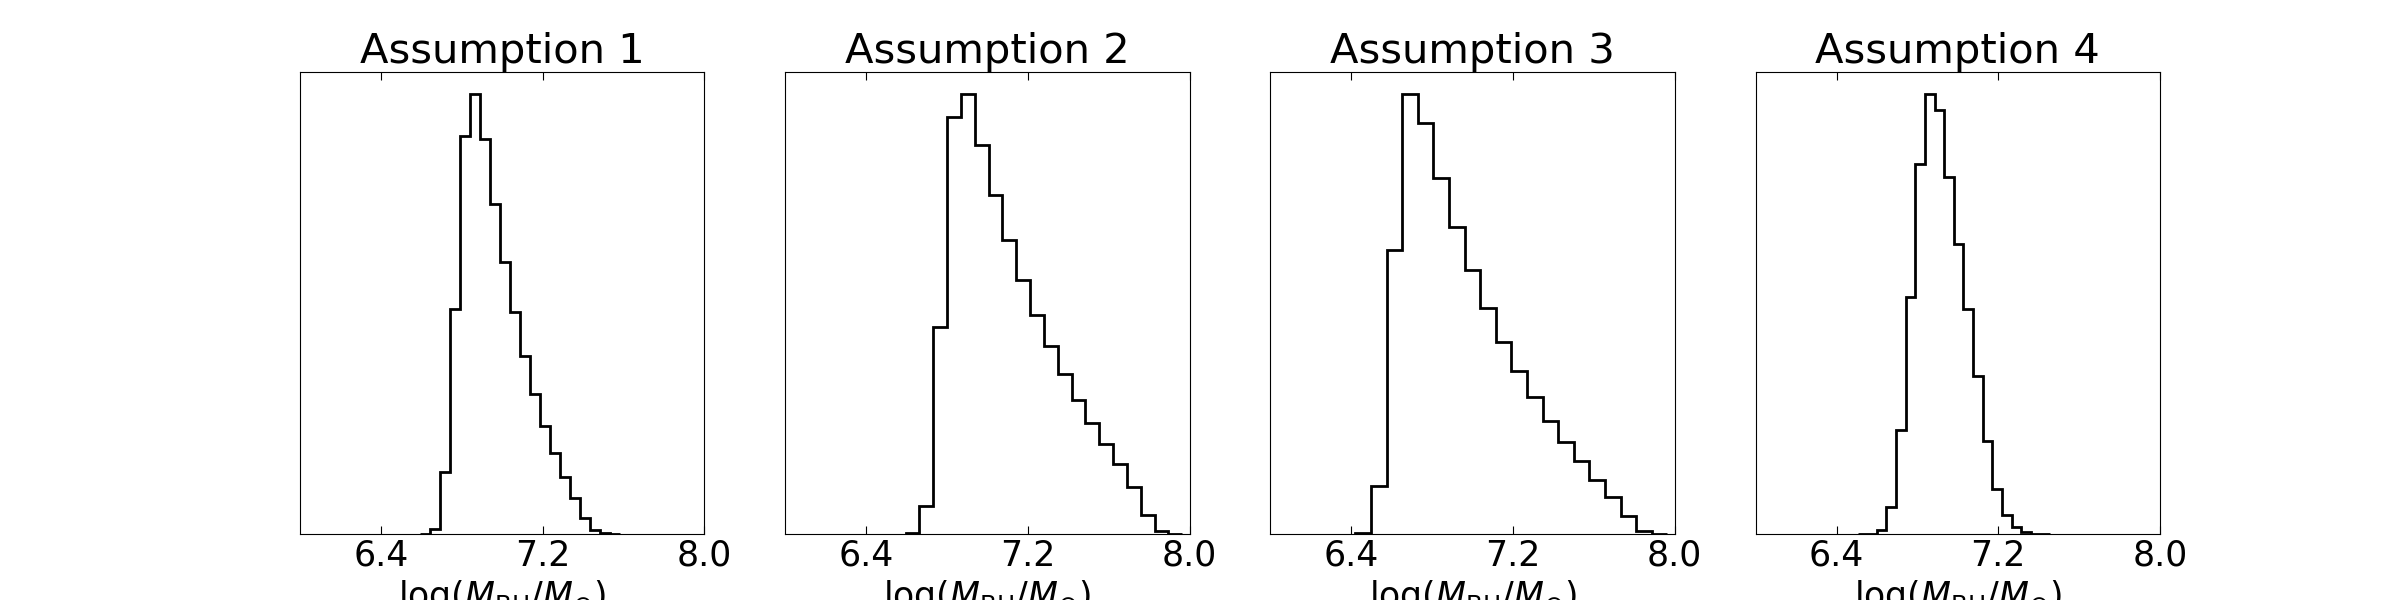

In [4]:
# Let's plot the distributions, and see how our assumptions change the indered M_BH distirbution

fig = plt.figure(figsize=(24, 6))
gs = GridSpec(1, 4, figure=fig, wspace=0.2, hspace=0.0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])


# Assumption 1: Face-on disk (i = 0), unknown prograde spin (0 < a < 0.99, flat PDF)
log_Mbh = np.log10(get_Mbh(Rins, i_min=0, i_max=0, a_min=0, a_max=0.99))
ax1.hist(log_Mbh, bins=20, color='black', histtype='step', lw=2)
ax1.yaxis.set_major_locator(NullLocator())
ax1.xaxis.set_major_locator(MaxNLocator(3, prune="lower"))
ax1.set_xlabel(r'$ {\rm log}( M_{\rm BH}/M_{\odot}$)')
ax1.set_title('Assumption 1')
ax1.set_xlim(6.0, 8.0)
percentiles = np.percentile(log_Mbh, [50, 16, 84])
med, perr, nerr = percentiles[0], percentiles[2] - percentiles[0],  percentiles[0] -  percentiles[1] # Just priting median and 68% of the posterior, you can define these are you wabt, e.g. mode and 90% of the posterior.
print(r'Assumption 1: $ {\rm log}( M_{\rm BH}/M_{\odot}) = %.2f^{+ %.2f}_{- %.2f}$'  % (med, perr,nerr))

# Assumption 2: unknown inclination (0 < i < 0.80, flat cos i PDF)), unknown prograde spin (0 < a < 0.99, flat PDF)
log_Mbh = np.log10(get_Mbh(Rins, i_min=0, i_max=80, a_min=0, a_max=0.99))
ax2.hist(log_Mbh, bins=20, color='black', histtype='step', lw=2)
ax2.yaxis.set_major_locator(NullLocator())
ax2.xaxis.set_major_locator(MaxNLocator(3, prune="lower"))
ax2.set_xlabel(r'$ {\rm log}( M_{\rm BH}/M_{\odot}$)')
ax2.set_title('Assumption 2')
ax2.set_xlim(6.0, 8.0)
percentiles = np.percentile(log_Mbh, [50, 16, 84])
med, perr, nerr = percentiles[0], percentiles[2] - percentiles[0],  percentiles[0] -  percentiles[1]
print(r'Assumption 2: $ {\rm log}( M_{\rm BH}/M_{\odot}) = %.2f^{+ %.2f}_{- %.2f}$'  % (med, perr,nerr))

# Assumption 3: unknown inclination (0 < i < 0.80, flat cos i PDF)), unknown full spin (-0.99 < a < 0.99, flat PDF)
log_Mbh = np.log10(get_Mbh(Rins, i_min=0, i_max=80, a_min=-0.99, a_max=0.99))
ax3.hist(log_Mbh, bins=20, color='black', histtype='step', lw=2)
ax3.yaxis.set_major_locator(NullLocator())
ax3.xaxis.set_major_locator(MaxNLocator(3, prune="lower"))
ax3.set_xlabel(r'$ {\rm log}( M_{\rm BH}/M_{\odot}$)')
ax3.set_title('Assumption 3')
ax3.set_xlim(6.0, 8.0)
percentiles = np.percentile(log_Mbh, [50, 16, 84])
med, perr, nerr = percentiles[0], percentiles[2] - percentiles[0],  percentiles[0] -  percentiles[1]
print(r'Assumption 3: $ {\rm log}( M_{\rm BH}/M_{\odot}) = %.2f^{+ %.2f}_{- %.2f}$'  % (med, perr,nerr))

# Assumption 4: unknown inclination (0 < i < 0.80, flat cos i PDF)), spin gaussian distributed a=0.0+/- 0.5
a_gaussian = np.random.normal(0, 0.2, 1000) # Creating a N=1000 Gaussian spin distribution
log_Mbh = np.log10(get_Mbh(Rins, i_min=0, i_max=80, a_dist=a_gaussian)) # change a_min and a_max to a_dist
ax4.hist(log_Mbh, bins=20, color='black', histtype='step', lw=2)
ax4.yaxis.set_major_locator(NullLocator())
ax4.xaxis.set_major_locator(MaxNLocator(3, prune="lower"))
ax4.set_xlabel(r'$ {\rm log}( M_{\rm BH}/M_{\odot}$)')
ax4.set_title('Assumption 4')
ax4.set_xlim(6.0, 8.0)
percentiles = np.percentile(log_Mbh, [50, 16, 84])
med, perr, nerr = percentiles[0], percentiles[2] - percentiles[0],  percentiles[0] -  percentiles[1]
print(r'Assumption 4: $ {\rm log}( M_{\rm BH}/M_{\odot}) = %.2f^{+ %.2f}_{- %.2f}$'  % (med, perr,nerr))
# It is clear, that in most cases, these are far from Gaussians, these is one of the reason the distribution need to be always fully accounted and propagating the unceranties and do not use gaussian approximation, for anything, do full PDF operations. 
# You have the full PDF, use them, plot them, make clear what is your ignorance and your assumptions on the parameters you derived.


# Outer disk radius estimation

Same thing, we have R_out/R_in, we want R_out/R_g. 

It is easy to show that R_out/R_g  only dpeendent on R_out/R_in (for which we have a distirbution) and the spin (which we do not know, and need to assume a distribution)

Formaally,  R_out/R_g =  R_out/R_in x gamma(a), where gamma(a) is the classical ISCO location in Rg's (Bardeen et al. 1972).

To get R_out/R_g, you can use the fuctions get_Rout_Rg, or you can mutiple element-by-element R_out/R_g x gamma(a).

$R_{\rm out}/R_{\rm g} = 38.2^{+ 11.9}_{- 13.7}$


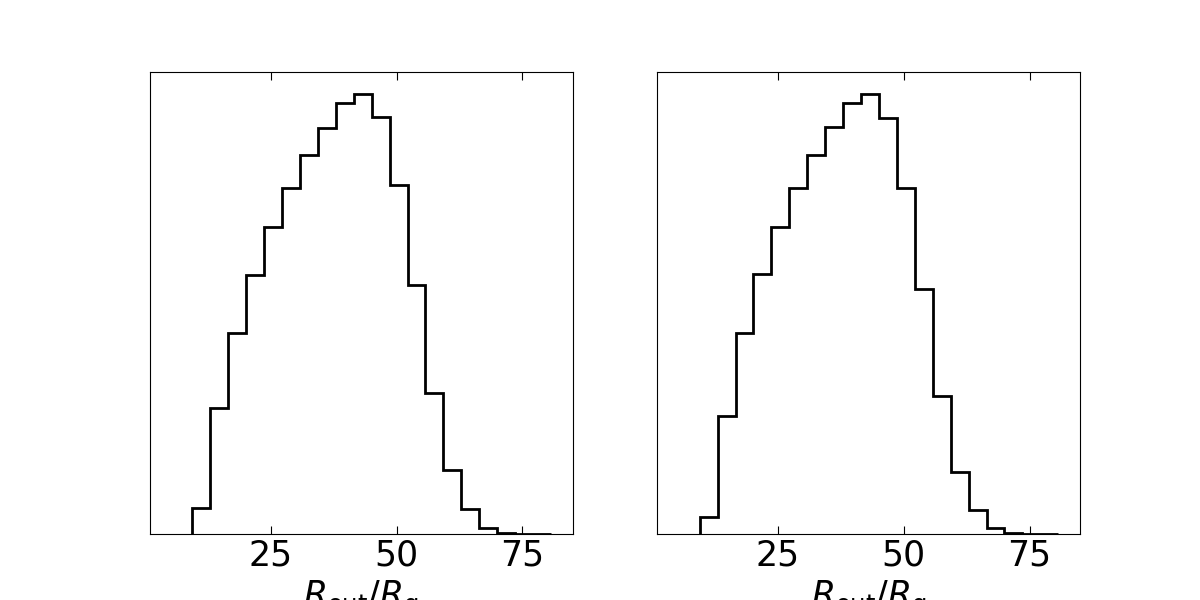

In [20]:
fig, axs = plt.subplots(1,2, figsize=(12,6))

# Using get_Rout_Rg
# Assuming unknown prograde spin (0 < a < 0.99, flat PDF)
Rout_Rg = get_Rout_Rg(R_ratio, a_min=0, a_max=0.99)
axs[0].hist(Rout_Rg, bins=20, color='black', histtype='step', lw=2)
axs[0].yaxis.set_major_locator(NullLocator())
axs[0].xaxis.set_major_locator(MaxNLocator(4, prune="lower"))
axs[0].set_xlim(1, 85)
axs[0].set_xlabel(r'$R_{\rm out}/R_{\rm g}$')

# Element-by-elemetn product
# Assuming unknown prograde spin (0 < a < 0.99, flat PDF)
a_dist = np.linspace(0, 0.99, 500)
gamma_a = f_a(a_dist) # I don't know why I called it gamma(a) as f_a... but now it late to change...
Rout_Rg = (np.multiply.outer(R_ratio, gamma_a)).flatten() # need to do a outer product, to make sure len(Rout_Rg) = len(R_ratio)*len(a_dist)
axs[1].hist(Rout_Rg, bins=20, color='black', histtype='step', lw=2)
axs[1].yaxis.set_major_locator(NullLocator())
axs[1].xaxis.set_major_locator(MaxNLocator(4, prune="lower"))
axs[1].set_xlim(1, 85)
axs[1].set_xlabel(r'$R_{\rm out}/R_{\rm g}$')
percentiles = np.percentile(Rout_Rg, [50, 16, 84])
med, perr, nerr = percentiles[0], percentiles[2] - percentiles[0],  percentiles[0] -  percentiles[1]
print(r'$R_{\rm out}/R_{\rm g} = %.1f^{+ %.1f}_{- %.1f}$'  % (med, perr,nerr))

# Bolometric Luminosity and Eddington Ratio

There is no analytical formula to calculate the Bolometric luminosity L_Bol of a disk with the outer radius as a free parameter. This requires numerical integration, which is done using the `get_bolometric` function from the posterior.

The Eddington ratio (= L_Bol/ L_Edd) can also be derived from the posterior. However, please avoid assuming that L_Bol and L_Edd are independent or follow Gaussian distributions—they do not! The propagation must be done element by element using the full posterior, which is handled by the `get_Edd_ratio` function.


In [27]:
# Loading fitting results.

outputfiles_basename = 'diskSED_run'
results = pd.read_csv(os.path.join(cwd, 'data', "%s/posterior.csv" %(outputfiles_basename))) 
print(results)

#We will need both Rin*, Tp, Rout/Rin. These need to be in a linear scale, so if you ran the fit in log-scale of any of those you need to linearlize first.

Rins = 10**results.values[:, 1] # Making linear scale
T_p = results.values[:,2] # Already linear scale
R_ratio = results.values[:, 3] # Already linear scale

            nH  log(R_in*)            T_p    R_ratio
0     0.045602    7.763546  236529.357565   8.960858
1     0.035781    7.660883  242657.502258  10.304841
2     0.045260    7.751310  237071.789130   8.869158
3     0.045389    7.760883  236466.129603   8.602193
4     0.029492    7.584427  247920.259372  11.934942
...        ...         ...            ...        ...
4192  0.041843    7.709481  240014.127889   9.113158
4193  0.051301    7.806496  234034.710357   8.025258
4194  0.046859    7.753542  237507.189838   9.304284
4195  0.050591    7.823075  232784.973476   7.433061
4196  0.036711    7.674126  241871.678821  10.105169

[4197 rows x 4 columns]


In [33]:
# Bolometric Luminosity

L_bol = get_bolometric(Rins[:100], T_p[:100], R_ratio[:100]) # This takes time to run! it will do numericall integration for every sample of posterior. 
#You can e.g. use only the first 100 elements of the posteiror to make it quicker. Remember nested sampling posteriors are randomly ordered, so the first 100 should be significant of the whole sample.

percentiles = np.percentile(L_bol, [50, 16, 84])
med, perr, nerr = percentiles[0], percentiles[2] - percentiles[0],  percentiles[0] -  percentiles[1]
print(r'$L_{\rm Bol} = %.1e^{+ %.1e}_{- %.1e}$'  % (med, perr,nerr))

$L_{\rm Bol} = 5.7e+44^{+ 9.1e+43}_{- 7.4e+43}$


In [37]:
# Eddington ratio

# For this we need a previous L_bol PDF. and Rins PDF. Same a and i assumptions as in get_M_BH are avalible.
# Assumption: unknown inclination (0 < i < 0.80, flat cos i PDF)), unknown prograde spin (0 < a < 0.99, flat PDF)
Edd_ratio = get_Edd_ratio(L_bol, Rins[:100], a_min=0.0, a_max=0.99, i_min=0, i_max=80)

percentiles = np.percentile(Edd_ratio, [50, 16, 84])
med, perr, nerr = percentiles[0], percentiles[2] - percentiles[0],  percentiles[0] -  percentiles[1]
print(r'$\lambda_{\rm Edd} = %.2f^{+ %.2f}_{- %.2f}$'  % (med, perr,nerr))

$\lambda_{\rm Edd} = 0.41^{+ 0.24}_{- 0.22}$
